# Binary Classifier 2
TJ Kim, 21 Oct 2019

We build a logistic regression model for the data in encoded_adult.csv. The inputs are all the encoded characteristics, while the output is whether or not the income is greater than 50k or not for a person (binary).

## Importing Data
First we import CSV data as pandas and divide to test and training set.

In [70]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import Dataset
filename = "adult_encoded.csv"
df = pd.read_csv(filename, sep='\s*,\s*',engine = 'python')
df = df.loc[:,df.columns != 'Unnamed: 0']

# Separate each dataset into training, testing, and query data
total_rest,total_test = train_test_split(df, random_state=30, test_size=0.2, shuffle=True)
total_train,queries = train_test_split(total_rest,random_state = 30, test_size = 0.4, shuffle = True)

# Separate each sub dataset to input and output
total_train_data = total_train.loc[:,total_train.columns != 'income_over_50k']
total_train_label = total_train.loc[:,total_train.columns =='income_over_50k']
total_test_data = total_train.loc[:,total_test.columns != 'income_over_50k']
total_test_label = total_train.loc[:,total_test.columns =='income_over_50k']
query_data = queries.loc[:,queries.columns !='income_over_50k']
query_label = queries.loc[:,queries.columns =='income_over_50k']

## Build and Run Logistic Binary Classifier
We use pandas to build dataframes and SKlearn's logistic regression based on string based classes

In [71]:
# Run Logistic Regression
logreg = LogisticRegression(solver="liblinear")
logreg.fit(total_train_data,total_train_label)

# Predict Test Result and calculate Accuracy
y_pred = logreg.predict(total_train_data)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(total_test_data, total_test_label)))

Accuracy of logistic regression classifier on test set: 0.85


/home/tkim/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Obtain Parameter Vector
Here we obtain what the parameter vector is so we can solve for it later on.

In [72]:
logreg.coef_.shape

(1, 39)

## Linear System of Equation Solving Attack

Next, we attack the binary logistic classifier we built by inputting d+1 predictions. "d" is the number of values in the weight vectors. It is important that we obtain confidence values rather than just binary classifications to make this possible

The number of linearly independent equations we need are 40. It will be a challenging and annoying task to ensure that every single equation we use is linearly independent.

We can simply take 40 values from the training data set.

In [73]:
# Function - calculate sigmoid inverse given output to sigmoid function, can take 2D vector inputs
def get_sigmoid_inv(out_val):
    idx = 0
    for i in out_val:
        if i == 1:
            out_val[idx] = 0.999999999999999
        idx += 1
    in_val = -1*np.log(np.divide(1,out_val) - 1)
    return in_val

In [84]:
# Get a appropriate number of samples from database to attack with
num_queries = logreg.coef_.size + 10
attack_sample = query_data.sample(num_queries)

# Divide data and labels
sample_x = attack_sample.loc[:,attack_sample.columns != 'income_over_50k']
sample_y = attack_sample.loc[:,attack_sample.columns =='income_over_50k']

# Obtain P(y = 1) vals for entire array - the confidence intervals for iris setosa (0) vs iris versicolor (1)
conf = logreg.predict_proba(sample_x)[:,1]
xw_s = get_sigmoid_inv(conf)
bias = np.ones((num_queries,1))
x_testvals = np.concatenate((bias, sample_x.values),1)

w_approx = np.linalg.lstsq(x_testvals,xw_s)
w_approx[0]

/home/tkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


array([-7.19385724e+00,  2.35303938e-02,  2.78343039e-01,  3.26189952e-04,
        6.59724190e-04,  2.53777187e-02, -3.68625872e-01, -7.76185172e-02,
       -1.85525491e-01, -7.35874694e-02,  2.00969977e-01, -4.80927000e-01,
        6.82047527e-02, -6.05873418e-01,  1.65156119e+00, -3.85432696e-01,
       -9.87628074e-01, -7.76185172e-02, -5.12118109e-01,  1.57678856e-01,
       -3.68625872e-01,  1.30365223e-01,  5.26725034e-02,  8.10699790e-01,
       -9.78605477e-01, -7.10185901e-01, -3.03221222e-01, -8.15155240e-01,
       -4.57793130e-02,  5.08309619e-01,  6.82047527e-02,  2.59356624e-01,
        5.68659616e-01, -9.38047222e-02, -2.91817460e-01,  0.00000000e+00,
       -4.13235507e-01,  1.04943815e-01, -3.17000468e-01,  1.40352244e-01])

In [76]:
real_weights = np.append(logreg.intercept_,logreg.coef_)
real_weights

array([-4.92799638e+00,  2.35303938e-02,  2.78343039e-01,  3.26189952e-04,
        6.59724190e-04,  2.53777187e-02, -8.46799222e-01, -2.15667320e-01,
       -7.74684418e-01, -6.62746396e-01, -3.88188950e-01, -1.07008593e+00,
       -9.69824143e-01, -1.19916952e+00,  1.05826509e+00, -9.78728801e-01,
       -1.58092418e+00, -1.12202475e+00, -1.10541421e+00,  1.57678856e-01,
       -7.90237960e-01, -1.80261287e-01, -2.57954007e-01,  5.00073279e-01,
       -1.28923199e+00, -1.02081241e+00, -6.13847733e-01, -1.12578175e+00,
       -3.56405823e-01,  1.97683109e-01,  2.06448210e-01, -5.12698864e-02,
        2.58033106e-01, -4.04431233e-01, -1.06459678e+00, -9.19769478e-01,
       -1.18601483e+00, -6.67835504e-01, -1.08977979e+00,  1.40352244e-01])

## Performance of Equation Solving Attack vs. Number of Queries

Show the performance of stolen classifier done by equation solving attacks. We take L2 norm of the parameters, as well as the prediction correctness rate of the stolen classifier.

In [144]:
query_num = np.arange(5,logreg.coef_.size + 100,2)
accs = np.zeros(query_num.size)
accs_idx = 0
og_acc = np.zeros(query_num.size)

for num in query_num:
    # take subset of query data and extract parameter vector based on LSQ minimizer
    attack_sample = query_data.sample(num)    
    sample_x = attack_sample.loc[:,attack_sample.columns != 'income_over_50k']
    conf = logreg.predict_proba(sample_x)[:,1]
    xw_s = get_sigmoid_inv(conf)
    bias = np.ones((num,1))
    x_testvals = np.concatenate((bias, sample_x.values),1)

    w_approx = np.linalg.lstsq(x_testvals,xw_s,rcond = None)
    w_approx = w_approx[0]
    
    # Take extracted parameter vector and test
    test_bias = np.ones((total_test_data.shape[0],1))
    test_data = np.concatenate((test_bias,total_test_data.values),1)
    pred_output = np.sign(np.matmul(test_data,w_approx))
    
    # Get accuracy of stolen
    real_label = total_test_label.values * 2 - 1
    accs[accs_idx] = 1- np.mean( real_label.T != pred_output)
    # Get accuracy of original non-stolen
    y_pred = logreg.predict(total_train_data)
    og_acc[accs_idx] = logreg.score(total_test_data, total_test_label)
    
    accs_idx += 1
    

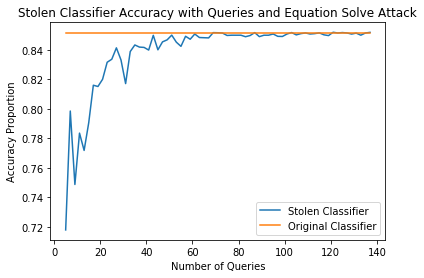

In [145]:
# Plot the accuracy
plt.plot(query_num,accs,label = "Stolen Classifier")
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Classifier Accuracy with Queries and Equation Solve Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Stolen Classifier','Original Classifier'))

ES_qn = query_num
ES_accs = accs

## Queries against performance in Uniform Attack

Next, we will sweep the number of queries to see how accuracy increases as we query more. This is done for the uniform attack where we have access to class labels only. We predict that the performance will be much lower compared to the equation solving attack.

In [147]:
from sklearn.metrics import accuracy_score


query_num1 = np.arange(20,100,2)
query_num2 = np.arange(100,logreg.coef_.size + 8000,100)
query_num = np.concatenate([query_num1, query_num2])
accs = np.zeros(query_num.size)
og_acc = np.zeros(query_num.size)

accs_idx = 0

for num in query_num:
    # take subset of query data and obtain labels from real classifier
    samp = query_data.sample(n=num)
    sweep_labels = logreg.predict(samp)
    
    # Build stolen classifier with output data
    model_sweep = LogisticRegression(solver="liblinear")
    model_sweep.fit(samp,sweep_labels)
    sweep_pred = model_sweep.predict(total_test_data)
    accs[accs_idx] = accuracy_score(total_test_label,sweep_pred)
    
    y_pred = logreg.predict(total_train_data)
    og_acc[accs_idx] = logreg.score(total_test_data, total_test_label)
    
    accs_idx += 1

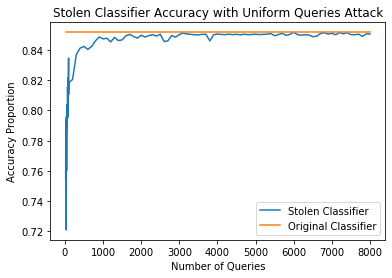

In [148]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Classifier Accuracy with Uniform Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Stolen Classifier','Original Classifier'))

## Comparing the Two Methods

We compare the performance of the equation solving attack and the uniform attack with each other. 

(0, 140)

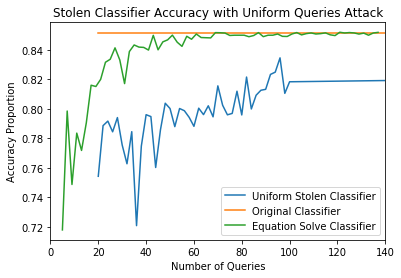

In [152]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.plot(ES_qn,ES_accs)
plt.title("Stolen Classifier Accuracy with Uniform Queries Attack")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")
plt.gca().legend(('Uniform Stolen Classifier','Original Classifier','Equation Solve Classifier'))
plt.xlim(0,140)